In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet201
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [2]:
datasetPath='..\kvasir-dataset-v2'
categories=[
    'dyed-lifted-polyps', 
    'dyed-resection-margins',
    'esophagitis',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]
EPOCHS = 25
Learing_Rate = 1e-3
Batch_Size = 32
img_rows = 160
img_cols = 160
img_size = (img_rows,img_cols)

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

In [4]:
data = []
labels = []

print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(datasetPath)))
random.seed(42)
random.shuffle(imagePaths)

printProgressBar(0, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)
for i,imagePath in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, img_size)
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    label = categories.index(label)
    labels.append(label)
    printProgressBar(i + 1, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)

print("[INFO] loading images completed...")

[INFO] loading images...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[INFO] loading images completed...


In [5]:
data = np.array(data, dtype="float") 
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

trainY = to_categorical(trainY, num_classes=8)
testY = to_categorical(testY, num_classes=8)

In [6]:
print ("number of training examples = " + str(trainX.shape[0]))
print ("number of test examples = " + str(testX.shape[0]))
print ("X_train shape: " + str(trainX.shape))
print ("Y_train shape: " + str(trainY.shape))
print ("X_test shape: " + str(testX.shape))
print ("Y_test shape: " + str(testY.shape))

number of training examples = 6000
number of test examples = 2000
X_train shape: (6000, 160, 160, 3)
Y_train shape: (6000, 8)
X_test shape: (2000, 160, 160, 3)
Y_test shape: (2000, 8)


In [7]:
generator = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

In [8]:
def buildModel(width, height, depth, classes):
    inputShape = (height, width, depth)
    if backend.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
    base_model = DenseNet201(
        input_shape=inputShape,
        include_top=False,
        weights='imagenet'
    )
    inputs = tf.keras.layers.Input([height, width, 3], dtype = tf.float32)
    model = tf.keras.applications.densenet.preprocess_input(inputs)
    base_model.trainable = True
    fine_tune_at = 600
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    model = base_model(model)
    model = GlobalAveragePooling2D()(model)
    model = Dense(1024,activation='relu')(model)
    model = Dropout(0.2)(model)
    model = Dense(512,activation='relu')(model)
    model = Dense(classes,activation='softmax')(model)
    model = Model(inputs = inputs, outputs = model)
    return model

In [10]:
print("[INFO] compiling model...")
model = buildModel(width=img_cols, height=img_rows, depth=3, classes=8)
model.summary()

[INFO] compiling model...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 5, 5, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)               

In [11]:
opt = Adam(lr=Learing_Rate, decay=Learing_Rate / EPOCHS)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt, 
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.SpecificityAtSensitivity(0.5,name="specificity")
    ]
)

In [12]:
print("[INFO] training network...")
history = model.fit(
    x=generator.flow(trainX, trainY, batch_size=Batch_Size),
    validation_data=(testX, testY), 
    steps_per_epoch=len(trainX) // Batch_Size,
    epochs=EPOCHS, 
    verbose=1)
print("[INFO] training network completed...")

[INFO] training network...
Epoch 1/25
187/187 [==============================] - 853s 5s/step - loss: 0.5647 - accuracy: 0.7832 - precision: 0.8118 - recall: 0.7562 - specificity: 0.9949 - val_loss: 0.3822 - val_accuracy: 0.8505 - val_precision: 0.8569 - val_recall: 0.8470 - val_specificity: 0.9979
Epoch 2/25
187/187 [==============================] - 842s 5s/step - loss: 0.3472 - accuracy: 0.8623 - precision: 0.8718 - recall: 0.8509 - specificity: 0.9987 - val_loss: 0.2693 - val_accuracy: 0.8980 - val_precision: 0.9016 - val_recall: 0.8930 - val_specificity: 0.9994
Epoch 3/25
187/187 [==============================] - 857s 5s/step - loss: 0.2930 - accuracy: 0.8837 - precision: 0.8898 - recall: 0.8765 - specificity: 0.9992 - val_loss: 0.2818 - val_accuracy: 0.8935 - val_precision: 0.8977 - val_recall: 0.8905 - val_specificity: 0.9989
Epoch 4/25
187/187 [==============================] - 971s 5s/step - loss: 0.2595 - accuracy: 0.8991 - precision: 0.9037 - recall: 0.8928 - specificity: 0

In [13]:
print("[INFO] saving model...")
model.save('Model_DenseNet_201-v2.model', save_format="h5")
print("[INFO] model saved")

[INFO] saving model...
[INFO] model saved


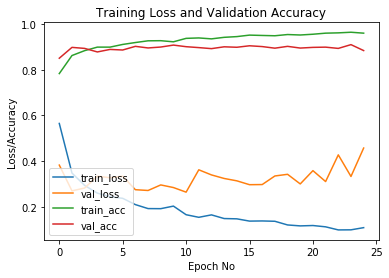

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Validation Accuracy")
plt.xlabel("Epoch No")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_DenseNet_201-v2.png')

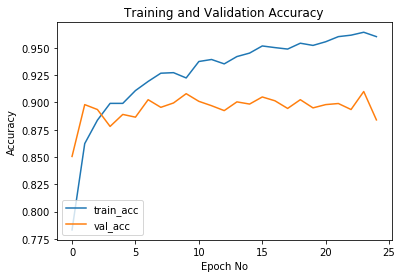

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch No")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_DenseNet201_Accuracy-v2.png')

In [ ]:
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch No")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_DenseNet201_Loss-v2.png')

In [ ]:
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
plt.plot(np.arange(0, N), history.history["specificity"], label="train_specificity")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
plt.plot(np.arange(0, N), history.history["val_specificity"], label="val_specificity")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Metrics")
plt.xlabel("Epoch No")
plt.ylabel("Value")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_DenseNet_201_metrics-v2.png')